# T03. Detecția liniște-vorbire în domeniul timp

În acest tutorial vom încerca să rezolvăm problema aparent simplă de a determina unde începe și unde se termină semnalul vocal. Această problemă este denumită și **voice activity detection** sau **endpoint detection** și este esențială pentru majoritatea aplicațiilor de prelucrare de semnal vocal.

Una dintre cele mai importante aplicații ale detecției liniște-vorbire este în cadrul aplicațiilor de transmisie a vorbirii (precum VoIP sau transmisiuni mobile). În cadrul acestora, pentru a reduce debitul de date, pe durata segmentelor de liniște se generează automat un zgomot aleator în loc de a transmite cadrele de semnal.

Înainte de a începe această analiză, trebuie să vizualizăm și să determinăm anumite caracteristici particulare ale semnalului vocal și a zgomotului. Astfel că, vom citi în primă fază un semnal ce conține atât voce, cât și liniște:

In [1]:
import wave
import numpy as np

input_wav_file = 'speech_files/adr_rnd1_002_noise2.wav'
wav_struct = wave.open(input_wav_file, 'r')
# Extragem frecvența de eșantionare
sampling_frequency = wav_struct.getframerate()

# Citim eșantioanele
wav_bytes = wav_struct.readframes(-1)

# Facem conversia la valori întregi
wav_data = np.frombuffer(wav_bytes, dtype='int16')
wav_data_int = wav_data

# Închidem fișierul de intrare
wav_struct.close()

Să-l vizualizăm și să-l ascultăm:

Duration 9.140271 second


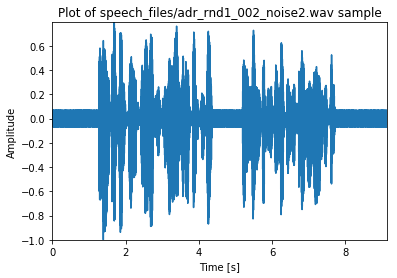

In [2]:
import matplotlib.pylab as pl
%matplotlib inline

# Normalizăm datele la [-1,1]
wav_data = wav_data/float(max(abs(wav_data)))

# Calculăm axa oY ca funcție de timp
time_axis = np.arange(0, len(wav_data))*1.00/sampling_frequency

# Calculăm durata totală a semnalului (în secunde)
duration = len(wav_data)*1.00/sampling_frequency
print ("Duration %f second" %duration)

# Afișăm semnalul
pl.plot(time_axis, wav_data)

pl.xlim([0, duration])
pl.ylim([min(wav_data), max(wav_data)])

pl.xlabel('Time [s]')
pl.ylabel('Amplitude')
pl.title("Plot of %s sample" %input_wav_file);

In [3]:
import IPython
IPython.display.Audio(wav_data, rate=sampling_frequency)

Extragem un cadru de vorbire și unul de liniște și le afișăm împreună:

In [4]:
window_length = int(20*1e-3*sampling_frequency)
# Cadru de vorbire
frame_no = 135
speech_frame = wav_data[window_length*frame_no: window_length*(frame_no+1)]
# Cadru de zgomot
frame_no = 1
noise_frame = wav_data[window_length*frame_no: window_length*(frame_no+1)]            

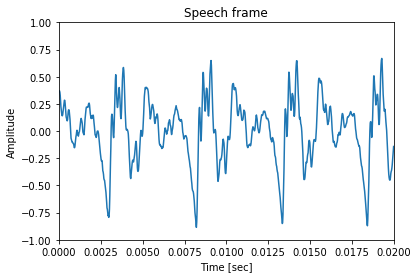

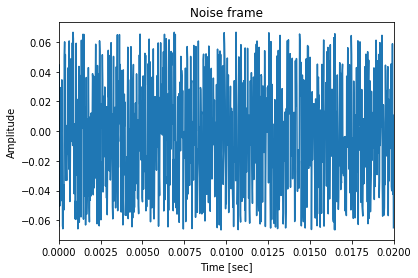

In [5]:
time_axis = np.arange(0, window_length)*1.00/sampling_frequency

# Afișăm cadrul de vorbire
pl.figure()
pl.plot(time_axis, speech_frame)
pl.xlabel('Time [sec]')
pl.ylabel('Amplitude')
pl.xlim((0, time_axis[-1]))
pl.ylim((-1,1))
pl.title("Speech frame")

# Afișăm cadrul de liniște/zgomot
pl.figure()
pl.plot(time_axis, noise_frame)
pl.xlabel('Time [sec]')
pl.ylabel('Amplitude')
pl.xlim((0, time_axis[-1]))
pl.title("Noise frame");

**(OBS)** Atenție la valorile de pe axa oY! Zgomotul are amplitudine mai mică.

<table>
<tr style="color:#FF5733; font-weight:bold">
    <td style="width:6%">
        <img src='images/ex5.png' width=50 align="left"> </td>
    <td style="text-align:left; font-size:1.2em">A. Ce se poate observa? Ce caracteristici ale semnalului ați folosi pentru a discrimina între voce și zgomot?
    </td>
</tr>
</table>

>Răspunsul vostru...

# Detecția liniște vorbire folosind NTZ și energia

Vom introduce în cele ce urmează două măsuri de bază ce ne pot ajuta să facem detecția liniște-vorbire: *numărul de treceri prin zero* și *energia*. Aceste măsuri sunt calculate din forma de undă a semnalului în domeniul timp.

**Numărul de treceri prin zero (NTZ)** (en. *zero crossing rate* - ZCR) este definit ca fiind egal cu numărul de intersectări ale semnalului cu axa oX.

<img src="images/02_ntz_graph.png">

Să implementăm calculul acestei măsuri folosindu-ne de faptul că înmulțirea a două numere are rezultat negativ doar atunci când numerele au semne opuse:

In [6]:
# Funcția de calcul a numărului de treceri prin zero
def ZCR(input_speech):
    zcr = 0
    for i in range(len(input_speech)-1):
      if input_speech[i]*input_speech[i+1] < 0:
        zcr+=1
    return zcr

**Energia** unui semnal discret este definită ca fiind suma amplitudinilor eșantioanelor semnalului:
>$E = \sum_{n=-\infty }^{\infty} \left | x(n)^{2} \right |$


Să implementăm calculul energiei ca funcție:

In [7]:
# Funcția de calcul a energiei semnalului
def energy (input_speech):
    ener = 0
    ener = sum([sample**2 for sample in input_speech])
    return ener

Odată ce avem aceste funcții, putem să calculăm cele două caracteristici pentru semnalul citit anterior și să afișăm variația lor de-a lungul întregului semnal:

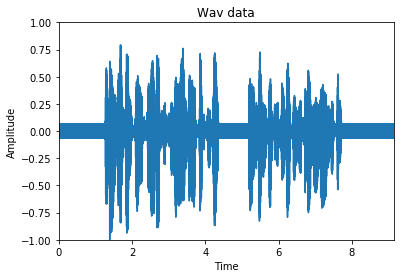

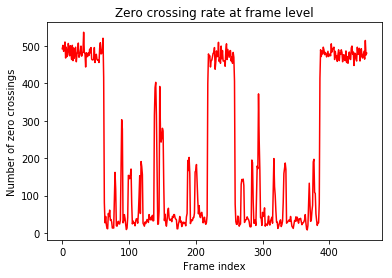

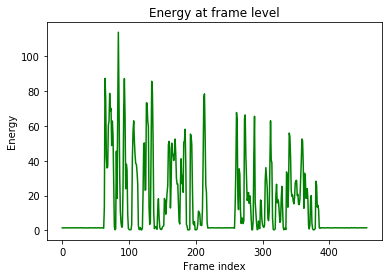

In [8]:
# Lungimea ferestrei de analiză ca număr de eșantioane
window_length = int(20*1e-3*sampling_frequency)

# Factorul de suprapunere a cadrelor
p = 0

# Numărul de cadre din semnal
number_of_frames = int(len(wav_data)/((1-p)*window_length))

# Creăm doi vectori cu valori nule în care vom stoca valorile
# energiei și NTZ din fiecare cadru de semnal
frames_zcr = [0]*number_of_frames
frames_energy = [0]*number_of_frames

# Parcurgem cadrele de semnal și calculăm energia și NTZ
for k in range(number_of_frames):
    current_frame = wav_data[k*window_length: (k+1)*window_length]
    frames_zcr[k] = ZCR(current_frame)
    frames_energy[k] = energy(current_frame)

# Axa de timp oX
time_axis = np.arange(0, len(wav_data))*1.00/sampling_frequency

# Plot semnal
pl.figure()
pl.plot(time_axis, wav_data)
pl.title('Speech data')
pl.xlabel('Time')
pl.ylabel('Amplitude')
pl.xlim([0, time_axis[-1]])
pl.ylim([-1, 1])

# Plot NTZ
pl.figure()
pl.plot(frames_zcr, 'r')
pl.title('Zero crossing rate at frame level')
pl.xlabel('Frame index')
pl.ylabel('Number of zero crossings')

# Plot energie
pl.figure()
pl.plot(frames_energy, 'g')
pl.title('Energy at frame level')
pl.xlabel('Frame index')
pl.ylabel('Energy');

În ploturile de mai sus putem observa că există o diferență clară între NTZ și energie pentru zonele de liniște/zgomot de fundal și cele de vorbire. Diferențele sunt rezumate în tabelul de mai jos:


<table>
    <tr style="text-align:center">
        <td></td>
        <td  style="text-align:center"><b>Vorbire</b></td>
        <td  style="text-align:center"><b>Liniște/Zgomot</b></td>
      </tr> 
      <tr  style="text-align:center">
          <td  style="text-align:center"><b>NTZ</b></td>
          <td  style="text-align:center">mic</td>
          <td  style="text-align:center">mare</td>
      </tr>
      <tr  style="text-align:center">
          <td  style="text-align:center"><b>Energie</b></td>
          <td  style="text-align:center">mare</td>
          <td  style="text-align:center">mică</td>
      </tr>
      

</table>

Pornind de la aceste observații, putem crea un prim algoritm de detecție liniște-vorbire. Deoarece NTZ și energia variază de la un semnal la altul, nu putem determina praguri absolute de detecție a liniștii și vorbirii. Astfel că, aceste praguri vor fi determinate direct din semnalul analizat.

Cel mai simplu algoritm de calcul este bazat pe estimarea numărului mediu NTZ și valoarea medie a energiei din primele 100 msec ale semnalului și de a face presupunerea că acest interval conține doar liniște/zgomot de fond. Pe baza acestor valori se stabilește mai apoi un prag proporțional de detecție a vorbirii/zgomotului. Și anume: dacă numărul de treceri prin zero dintr-un cadru de semnal scade sub acest prag, iar energia este peste pragul calculat, cadrul conține zgomot/liniște. Prin inversarea condițiilor, se obține cadrul de vorbire.

Implementăm acest algoritm în cele ce urmează:

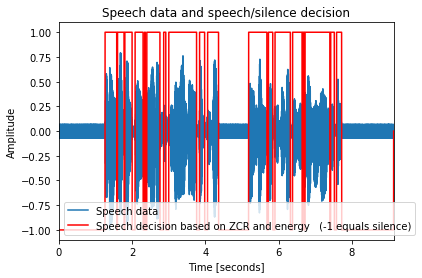

In [9]:
# Calculăm valoarea medie a NTZ și energiei pentru primele 100msec de semnal
# NOTA: În această situație un cadru are lungimea de 20msec, deci
# trebuie să folosim primele 5 cadre
zcr_mean = sum(frames_zcr[:5])/5
energy_mean = sum(frames_energy[:5])/5

# Stabilim o valoare a pragului proporțional (60%) din valorile calculate
# anterior
threshold = 0.6

# Calculăm valorile pragurilor proporționale pentru NTZ și energie
zcr_threshold = threshold*zcr_mean
energy_threshold = threshold*energy_mean


# Inițializăm un vector de decizie voce/zgomot
speech_decision = np.zeros(number_of_frames)

# Trecem prin toate cadrele de semnal și determinăm dacă valorile NTZ 
# și energie pentru cadrul respectiv sunt sub sau peste pragurile 
# determinate anterior
for k in range(number_of_frames):
    if frames_zcr[k] < zcr_threshold and frames_energy[k] > energy_threshold:
        speech_decision[k] = 1
    else:
        speech_decision[k] = -1

# Creăm un vector de lungime egală cu semnalul de intrare
# pentru a putea afișa mai bine rezultatele
speech_decision_plot = np.zeros(len(wav_data))        
for k in range(number_of_frames):
    speech_decision_plot[k*window_length:(k+1)*window_length] = speech_decision[k]
        
# Afișăm rezultatele 
time_axis = np.arange(0, len(wav_data))*1.00/sampling_frequency

pl.plot(time_axis, wav_data)
pl.plot(time_axis, speech_decision_plot,'r')
pl.title('Speech data and speech/silence decision')
pl.xlabel('Time [seconds]')
pl.ylabel('Amplitude')
pl.xlim([0, time_axis[-1]])
pl.ylim([-1.1, 1.1])
pl.legend(['Speech data', 'Speech decision based on ZCR and energy \
  (-1 equals silence)']);

Putem observa că acest algoritm simplu are anumite probleme, iar deciziile sale nu sunt în conformitate cu ceea ce ne-am fi așteptat să obținem. Acest lucru se datorează faptului că anumite segmente de vorbire au caracteristici similare cu cele ale zgomotului. De exemplu, consoanele *s* și *ș*  au forma de undă foarte apropiată de cea a zgomotului alb gausian. Vom discuta în tutorialul următor mai multe despre caracteristicile segmentelor sonore individuale.

<table>
<tr style="color:#FF5733; font-weight:bold">
    <td style="width:6%">
        <img src='images/ex4.png' width=50 align="left"> </td>
    <td style="text-align:left; font-size:1.2em">F. Modificați valoarea pragului și analizați rezultatele
    </td>
</tr>
</table>

In [10]:
###################
##YOUR CODE HERE
###################

<table>
<tr style="color:#FF5733; font-weight:bold">
    <td style="width:6%">
        <img src='images/ex2.png' width=50 align="left"> </td>
    <td style="text-align:left; font-size:1.2em">G. De ce sunt detectate cadre de voce în zonele de liniște?
    </td>
</tr>
</table>

>Your answer here...

O primă soluție la aceste probleme este de a media decizia de-a lungul mai multor cadre, deoarece e puțin probabil ca un singur cadru de semnal să fie diferit de cele din jur. Astfel că vom verifica dacă decizia pentru fiecare cadru e diferită de cele două adiacente. În caz afirmativ, modificăm decizia inițială:

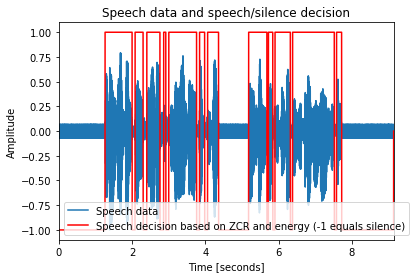

In [11]:
# Dacă există un singur cadru de voce înconjurat de liniște
# sau invers, vom modifica decizia pentru acel cadru 
for k in range(1, number_of_frames-1):
    if (speech_decision[k] != speech_decision[k-1]) and \
            (speech_decision[k] != speech_decision[k+1]):
        speech_decision[k] = speech_decision[k+1]

# Creăm un vector de lungime egală cu lungimea semnalului de intrare
# pentru afișare
speech_decision_plot = np.zeros(len(wav_data))        
for k in range(number_of_frames):
    speech_decision_plot[k*window_length:(k+1)*window_length] = speech_decision[k]
    
# Afișăm rezultatele       
time_axis = np.arange(0, len(wav_data))*1.00/sampling_frequency

pl.plot(time_axis, wav_data)
pl.plot(time_axis, speech_decision_plot,'r')
pl.title('Speech data and speech/silence decision')
pl.xlabel('Time [seconds]')
pl.ylabel('Amplitude')
pl.xlim([0, time_axis[-1]])
pl.ylim([-1.1, 1.1])
pl.legend(['Speech data', 'Speech decision based on ZCR and energy (-1 equals silence)']);

Nici acest lucru nu a  generat rezultate mult mai bune...

Un algoritm mai complex și eficient în domeniul timp este Rabiner-Sambur:

[1] L.R. Rabiner and M.R. Sambur - "An Algorithm for Determining the Enpoints of Isolated Utterances", The Bell Systems Technical Journal, vol. 54, no.2, pp. 297-315, February 1975. Online: https://ia800309.us.archive.org/15/items/bstj54-2-297/bstj54-2-297.pdf

Notă: Pentru ca algoritmul să funcționeze corect, la fel ca și mai sus, primele 100msec de semnal trebuie să conțină doar liniște.

<table style="width:100%">
<tr style="color:#FF5733; font-weight:bold">
    <td style="width:6%">
        <img src='images/ex1.png' width=50 align="left"> </td>
    <td style="text-align:left; font-size:1.2em">H. Rulați din nou algoritmul de mai sus pentru fișierul  adr_rnd1_001.wav din directorul speech_files/. Ce se întâmplă? 
    </td>
</tr>
</table>

In [12]:
###################
##YOUR CODE HERE
###################

<table style="width:100%">
<tr style="color:#FF5733; font-weight:bold">
    <td style="width:6%">
        <img src='images/ex5.png' width=50 align="left"> </td>
    <td style="text-align:left; font-size:1.2em">I. Cum ați rezolva problemele algoritmului nostru simplu? 
    </td>
</tr>
</table>

>Your answer here...

<table style="width:100%">
<tr style="color:#FF5733; font-weight:bold">
    <td style="width:6%">
        <img src='images/ex6.png' width=50 align="left"> </td>
    <td style="text-align:left; font-size:1.2em">J. Implementați algoritmul Rabiner-Sambur algorithm și evaluați rezultatele
    </td>
</tr>
</table>

In [13]:
###################
##YOUR CODE HERE
###################

# Detecția liniște vorbire folosind caracteristici spectrale probabilistice

Sau putem să utilizăm un algoritm de detecție liniște vorbire deja implementat, cum ar fi cel disponibil la această adresă  https://github.com/wiseman/py-webrtcvad/ . Algoritmul folosește metode probabilistice de estimare a caracteristicilor spectrale ale vocii și zgomotului. Întelegerea modului de funcționare a acestuia la momentul actual nu este necesară, ci dorim doar să exemplificăm modul în care detecția liniște vorbire ar trebui să aibă loc în practică.

Pentru a instala modulul vom folosi utilitarul `pip`:

In [14]:
!pip install webrtcvad

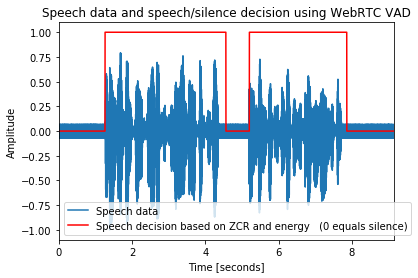

In [15]:
# Importăm modulul
import webrtcvad

# Instanțiem un obiect de tip VAD
vad = webrtcvad.Vad()

# Setăm modul de operare (v. documentația)
vad.set_mode(3)

# Parcurgem cadru cu cadru semnalul și reținem decizia VAD
speech_decision = np.zeros(number_of_frames)
for k in range(number_of_frames):
    current_frame = wav_data_int[k*window_length: (k+1)*window_length]
    speech_decision[k] = int(vad.is_speech(current_frame, sampling_frequency))
    #print (vad.is_speech(current_frame, sampling_frequency))

# Creăm un vector de lungime egală cu semnalul de intrare
# pentru a putea afișa mai bine rezultatele
speech_decision_plot = np.zeros(len(wav_data))        
for k in range(number_of_frames):
    speech_decision_plot[k*window_length:(k+1)*window_length] = speech_decision[k]
        
# Afișăm rezultatele 
time_axis = np.arange(0, len(wav_data))*1.00/sampling_frequency

pl.plot(time_axis, wav_data)
pl.plot(time_axis, speech_decision_plot,'r')
pl.title('Speech data and speech/silence decision using WebRTC VAD')
pl.xlabel('Time [seconds]')
pl.ylabel('Amplitude')
pl.xlim([0, time_axis[-1]])
pl.ylim([-1.1, 1.1])
pl.legend(['Speech data', 'Speech decision based on ZCR and energy \
  (0 equals silence)']);
    

Se poate observa că spre deosebire de algoritmul nostru simplu, acesta din urmă realizează o detecție corectă a segmentelor de liniște și vorbire. Studiul algoritmilor VAD este în continuare de mare interes în comunitarea știintifică, în special în cazurile în care zgomotul de fond acoperă în proporție foarte mare semnalul vocal.

# Concluzii

În cadrul acestui tutorial am introdus noțiunile de număr de treceri prin zero și energie și am văzut modul în care acestea pot fi utilizate pentru discriminarea dintre segmentele de voce și cele de zgomot/liniște de fundal. Cu toate că aceste măsuri în sine pot realiza o oarecare discriminare, în aplicații practice, datorită variabilității mari a semnalelor și a tipurilor de zgomot, simpla analiză a formei de undă a unui semnal vocal nu este suficientă pentru crearea unui algoritm eficient. 